In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
%matplotlib inline
np.random.seed(1)

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

(1080, 64, 64, 3)
(1, 1080)
(120, 64, 64, 3)
(1, 120)
y = 5


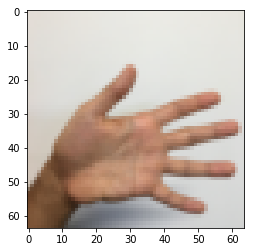

In [4]:
print(X_train_orig.shape)
print(Y_train_orig.shape)
print(X_test_orig.shape)
print(Y_test_orig.shape)
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [5]:
def one_hot_matrix(labels,C):
    one_hot_m=tf.one_hot(indices=labels,depth=C,axis=0)
    sess=tf.Session()
    one_hot=sess.run(one_hot_m)
    sess.close()
    return one_hot
    

In [7]:
labels = np.array([1,2,3,0,2,1])
one_hot = one_hot_matrix(labels, C = 4)
print ("one_hot = " + str(one_hot))

one_hot = [[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [10]:
X_train_flatten=X_train_orig.reshape(X_train_orig.shape[0],-1).T
X_test_flatten=X_test_orig.reshape(X_test_orig.shape[0],-1).T

X_train=X_train_flatten/255
X_test=X_test_flatten/255
Y=np.squeeze(Y_train_orig)

Y_train=one_hot_matrix(np.squeeze(Y_train_orig),6)
Y_test=one_hot_matrix(np.squeeze(Y_test_orig),6)
print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [21]:
def create_placeholders(n_x,n_y):
    X=tf.placeholder(tf.float32,[n_x,None],name='X')
    Y=tf.placeholder(tf.float32,[n_y,None],name='Y')
    return X,Y

In [34]:
def intialize_parameters(layers_dims):
    parameters={}
    for i in range(1,len(layers_dims)):
        parameters["W"+str(i)]=tf.get_variable("W"+str(i),[layers_dims[i],layers_dims[i-1]],initializer=tf.contrib.layers.xavier_initializer(seed=1))
                                               
        parameters["b"+str(i)]=tf.get_variable("b"+str(i),[layers_dims[i],1],initializer=tf.zeros_initializer())
        
    return parameters     

In [42]:
def forward_propagation(X,parameters):
    L=len(parameters)//2
    A=X
    for l in range(1,L):
       Z=tf.add(tf.matmul(parameters["W"+str(l)],A),parameters["b"+str(l)])
       A=tf.nn.relu(Z)
    Z=tf.add(tf.matmul(parameters["W"+str(L)],A),parameters["b"+str(L)])
    return Z       

In [23]:
def compute_cost (Z,Y):
    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return cost

In [28]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    np.random.seed(seed)
    m=X.shape[1]
    mini_batchs=[]
    
    permutation=np.random.permutation(m)
    
    X_shuffled=X[:,permutation]
    Y_shuffled=Y[:,permutation]

    L=math.floor(m/mini_batch_size)
    
    for l in range(L):
        
        mini_batchs_X=X_shuffled[:,mini_batch_size*l:mini_batch_size*(l+1)]
        mini_batchs_Y=Y_shuffled[:,mini_batch_size*l:mini_batch_size*(l+1)]
        mini_batchs.append((mini_batchs_X,mini_batchs_Y))
    if L*mini_batch_size<m:
        mini_batchs_X=X_shuffled[:,mini_batch_size*L:m]
        mini_batchs_Y=Y_shuffled[:,mini_batch_size*L:m]
        mini_batchs.append((mini_batchs_X,mini_batchs_Y))
    return mini_batchs

In [46]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.0001,num_epoches=1500,minibatch_size=32,print_cost=True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    costs=[]
    n_x=X_train.shape[0]
    n_y=Y_train.shape[0]
             
    
    
    layers_dims=[X_train.shape[0],25,12,6]
    parameters=intialize_parameters(layers_dims)
    X,Y=create_placeholders(n_x,n_y)  
    Z=forward_propagation(X,parameters)
    cost=compute_cost (Z,Y)
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init=tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_epoches):
            epoch_cost=0
            seed = seed + 1
            minibatchs=random_mini_batches(X_train,Y_train,mini_batch_size=minibatch_size,seed = seed)
                       
            for minibatch in minibatchs:
                (X_minibatch,Y_minibatch)=minibatch
                _,minibatch_cost=sess.run([optimizer,cost],feed_dict={X:X_minibatch,Y:Y_minibatch})
                epoch_cost+= minibatch_cost
            if print_cost==True and i%100==0:
                print("Cost after epoch%i:%f" %(i,epoch_cost))
            if print_cost==True and  i%5 ==0:
                costs.append(epoch_cost)
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
    
        # Calculate the accuracy
        correct_prediction=tf.equal(tf.argmax(Z),tf.argmax(Y))
        accuracy=tf.reduce_mean(tf.cast(correct_prediction,"float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y:Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        return parameters

Cost after epoch0:61.238164
Cost after epoch100:33.543110
Cost after epoch200:24.192380
Cost after epoch300:18.906955
Cost after epoch400:15.470360
Cost after epoch500:12.572311
Cost after epoch600:10.356022
Cost after epoch700:8.390524
Cost after epoch800:6.725233
Cost after epoch900:5.491522
Cost after epoch1000:4.669409
Cost after epoch1100:3.550091
Cost after epoch1200:2.845542
Cost after epoch1300:1.960706
Cost after epoch1400:1.723835


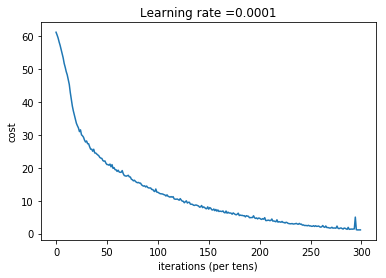

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.71666664


In [47]:
parameters = model(X_train, Y_train, X_test, Y_test)